In [3]:
#from structure_and_load import load
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.ndimage as spn 
import seaborn as sns
from itertools import combinations
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline

from open_data  import matlab_file
from structure_data import  manage
from measures import ISI, FiringRate, tools
from classify import HistGrad

import re
import neo 
from neo.core import Event
from quantities import s 
from quantities import millisecond as ms


import os
import sys

%load_ext autoreload
%autoreload 2

# Load and format data

### Load data

In [4]:
lab_desktop = True
if lab_desktop : 
    result_path = '/home/INT/mifsud.l/Bureau/pattern_classification_git/results/'

else : 
    result_path = '/home/laurie/Bureau/pattern_classification_git/results/'

In [5]:
#Load
session, data_path, info_path = matlab_file.from_lab(lab_desktop=lab_desktop, session='t150204001')
data, load_info = matlab_file.open(data_path)
session_info_raw = matlab_file.clean(info_path)


43 files loaded


In [6]:
# get sessions and units information (unit, prob, elitrials)
info_units,  info_session = manage.info(load_info, session_info_raw, session)
unit_label, unit_labelProbe1, unit_labelProbe2, count_unitProbe = manage.units_label(info_units)
# manage elitrials format
info_session['elitrials'] = info_session['elitrials'].apply(manage.elitrials)
info_session.to_csv(result_path + 'info_session.csv')

# get unit's index without eli trials 
completeUnit = manage.CompleteTasktime(info_session, load_info, session)
unit_label[:5]

Complete unit found ! 
loading index = 2
matfile : t150204001_probe1_contact3_unit1.mat


['P1-23-2', 'P1-5-1', 'P1-3-1', 'P1-1-1', 'P2-6-1']

In [7]:
spike_times, task_times, target_info = matlab_file.extract_data(\
        load_info, data, target_keys_OFF=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'],\
        target_keys_ON=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'], \
        event_keys_OFF=[])
        #event_keys_OFF=['Sel_OFF', 'SC1_OFF', 'SC2_OFF', 'SC3_OFF']

### Format spike times 

In [8]:
event_labels = matlab_file.get_event_labels(task_times)
event_times = matlab_file.get_event_times(task_times, event_labels)
# reshape times by trials / periods for each neuron + Neo format
trials_ts, df_task_ts_by_neuron, events = manage.events_by_trial(event_times, event_labels)

In [9]:
np.save(result_path + 'event_labels.npy', event_labels)

In [10]:
unit_ = 32
trial_ = 12
print(f'times as list : {trials_ts[unit_][1][trial_]}')
print(f'times as neo events : {events[unit_][1][trial_].times}')
print(f'spike train sample : {spike_times[0][1]}\nevents : {event_labels}\ntargets : {task_times[0][1].keys()}')


times as list : [3047992 3049069 3049390 3050391 3050712 3051713 3052020 3053021 3053341
 3054320 3054799]
times as neo events : [3047992. 3049069. 3049390. 3050391. 3050712. 3051713. 3052020. 3053021.
 3053341. 3054320. 3054799.] ms
spike train sample : [    237    2137    3267 ... 3657198 3657250 3658579]
events : ['Touch_time', 'Sel_ON', 'Sel_OFF', 'SC1_ON', 'SC1_OFF', 'SC2_ON', 'SC2_OFF', 'SC3_ON', 'SC3_OFF', 'Go_time', 'Target_time']
targets : dict_keys(['Touch_time', 'Sel_ON', 'Sel_OFF', 'SC1_ON', 'SC1_OFF', 'SC2_ON', 'SC2_OFF', 'SC3_ON', 'SC3_OFF', 'Go_time', 'Target_time'])


In [12]:
# get dataframe with each events times per trials for a complete session
t = 0
tot_trials_in_task = trials_ts[completeUnit][1].shape[0]
df_task_ts = pd.DataFrame(trials_ts[completeUnit][1], columns=event_labels, index=np.arange(0, tot_trials_in_task))
df_task_ts.tail()

event_vector = df_task_ts.loc[t] - df_task_ts.iloc[t,0]
event_vector = event_vector.values
print(event_vector)
np.save(result_path + 'event_vector.npy', event_vector)

[   0 1077 1395 2396 2703 3704 4025 5025 5333 6310 6923]


### Format target

In [13]:
target = manage.target_by_trials(target_info, completeUnit)
target.to_csv(result_path + 'target.csv')
target

,trial_type,position,type_and_pos
0,1,2,0
1,1,2,0
2,1,3,1
3,1,3,1
4,1,4,2
...,...,...,...
171,1,3,1
172,2,3,4
173,2,4,5
174,2,4,5


### Format trials

In [14]:
# align times by trials for each neurons
df_task_ts_by_neuron = manage.time_by_trials(df_task_ts_by_neuron, df_task_ts, event_labels)
df_task_ts_by_neuron[0][1]

# split the spike time vector by trial
spk_trials, spike_train_trial = manage.spike_ts_by_trial(trials_ts, spike_times)
spikes_times_aligned = manage.spike_ts_aligned(df_task_ts, df_task_ts_by_neuron, spike_times, unit_label, spike_train_trial)

/home/INT/mifsud.l/Bureau/pattern_classification_git/pipeline_drafts/structure_data/manage.py:360: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_start = data.iloc[idx_trial_valid][1]
/home/INT/mifsud.l/Bureau/pattern_classification_git/pipeline_drafts/structure_data/manage.py:361: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_stop = data.iloc[idx_trial_valid][-1]
/home/INT/mifsud.l/Bureau/pattern_classification_git/pipeline_drafts/structure_data/manage.py:383: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent 

# Raster plot

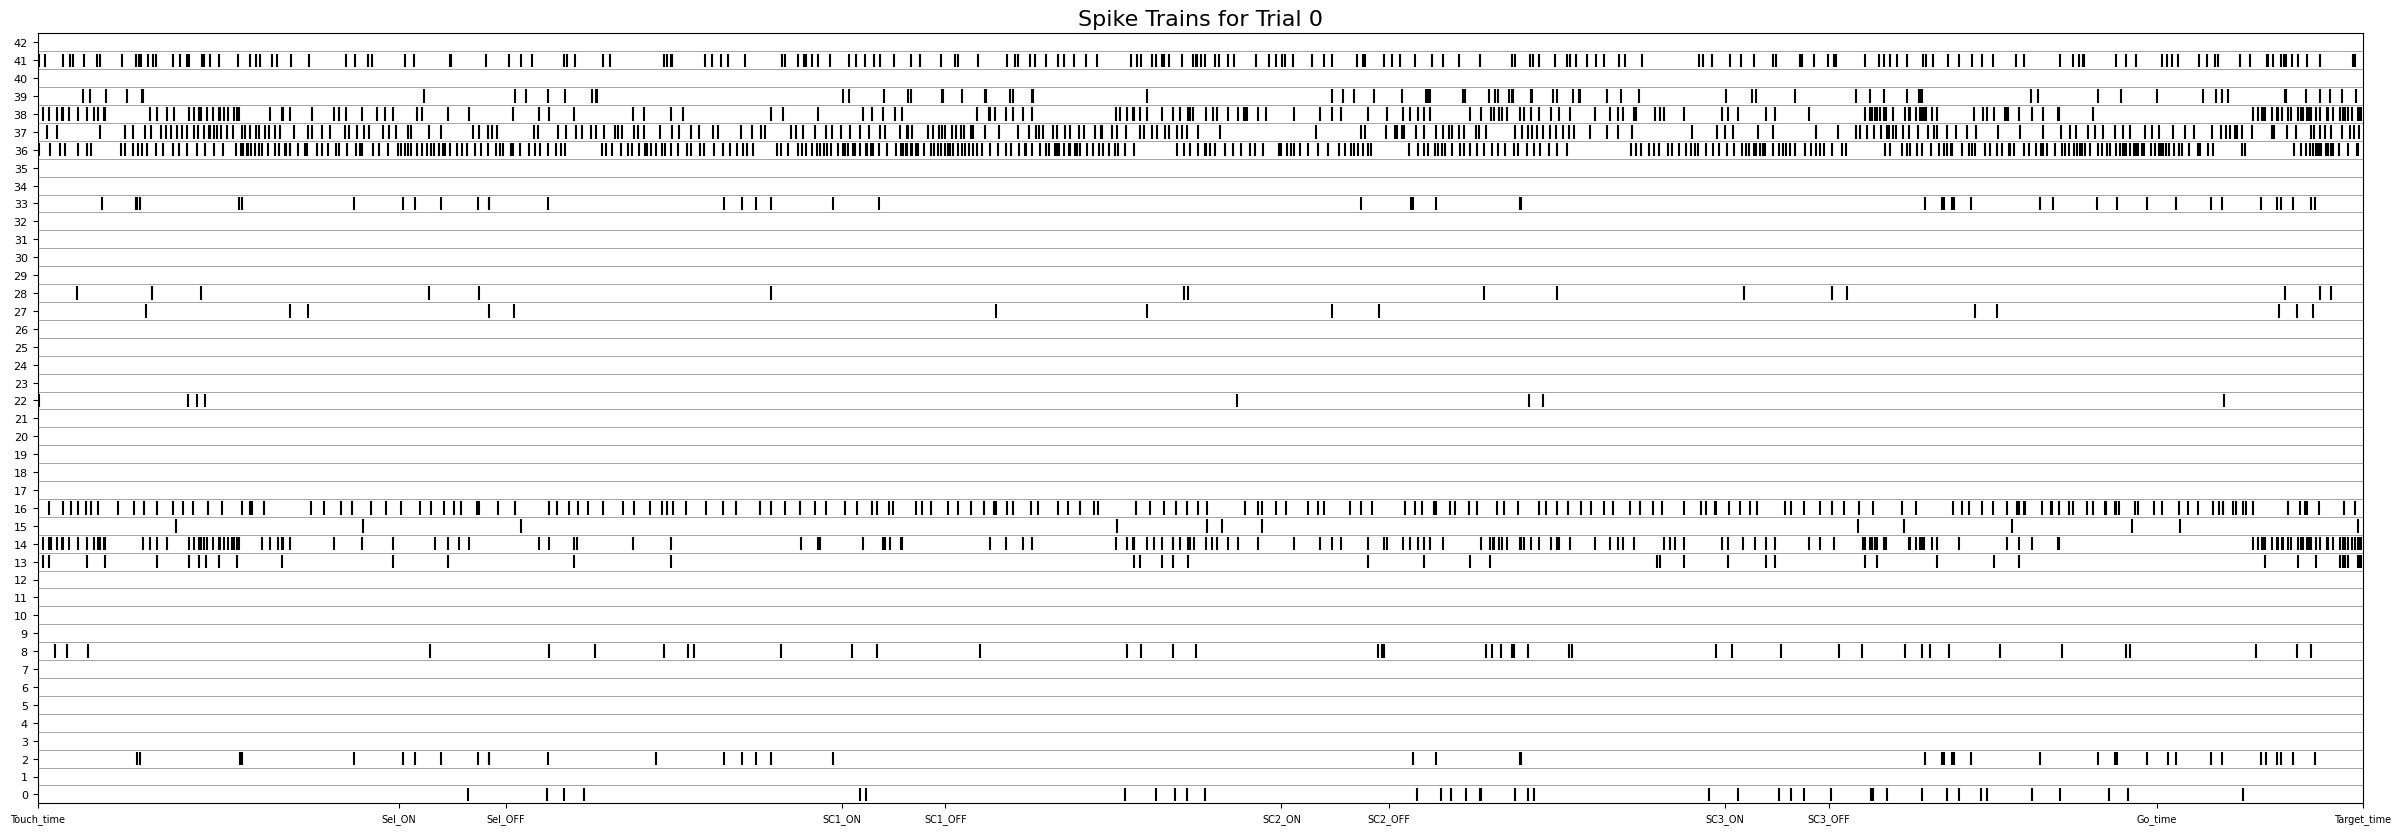

In [15]:
n_neurons = spikes_times_aligned.shape[0]

t = 0
event_vector = df_task_ts.loc[t]

plt.figure(figsize=(30, 10))  # Ajustez la taille de la figure selon vos besoins

# Parcourir tous les neurones et tracer leur spike train
for n in range(n_neurons): 
    spiketrain = spikes_times_aligned[n][t]['spike_train']
    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        plt.eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=n, color='black')
for i in range(n_neurons - 1):
    plt.hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
plt.xticks(event_vector.values, event_labels, fontsize=7)
plt.yticks(range(n_neurons), [f"{i}" for i in range(n_neurons)], fontsize=8)
plt.title(f"Spike Trains for Trial {t}", fontsize=16)

# Ajuster les limites des axes
plt.xlim(event_vector.min(), event_vector.max())
plt.ylim(-0.5, 42.5)

plt.show()


# Compute measure

In [16]:
def destroy_corr(x, y):
    rng = np.random.default_rng() #ramdom seed
    n_samples, n_times, n_feat = x.shape 
    y_u = np.unique(y)
    x_dc = x.copy()

    for n_y in y_u:
        is_class = y == n_y
        x_dc[is_class, :, :] = rng.permuted(x[is_class, :, :], axis=0)
    return x_dc

## Instantaneous Firing rate 

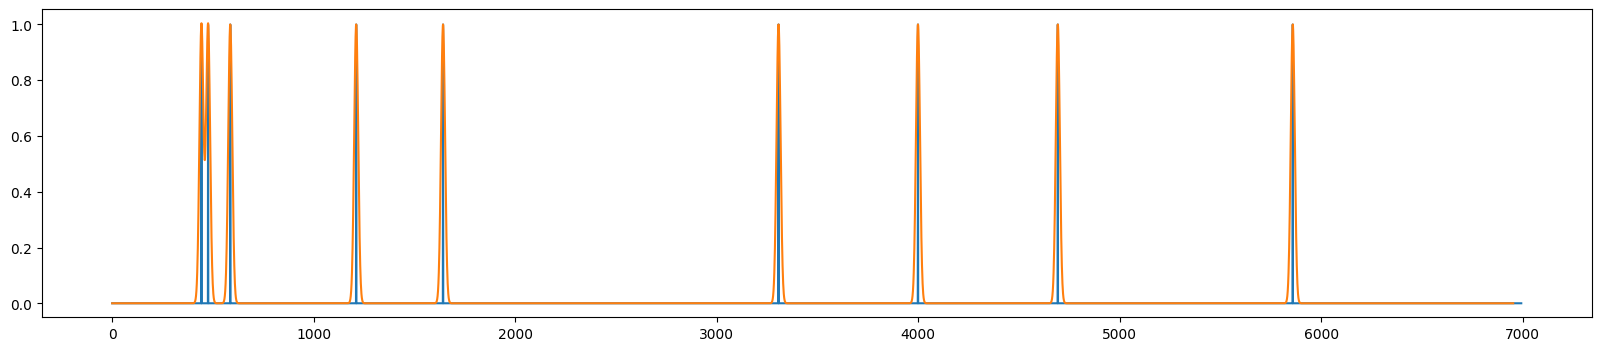

In [18]:
sigma = [10]
max_length = tools.get_max_length_trials(spikes_times_aligned[-1])
spikes_binarized = FiringRate.binarize_spike_times(spikes_times_aligned, max_length)
spike_convolved = FiringRate.convolve_spike_binarized(spikes_binarized, sigma)

plt.figure(figsize=(20,4))
plt.plot(spikes_binarized[128,:,0])
plt.plot(spike_convolved[128,:,0])
np.save(result_path + 'spike_convolved.npy', spike_convolved)

## Instantaneous Shuffled Firing rate 

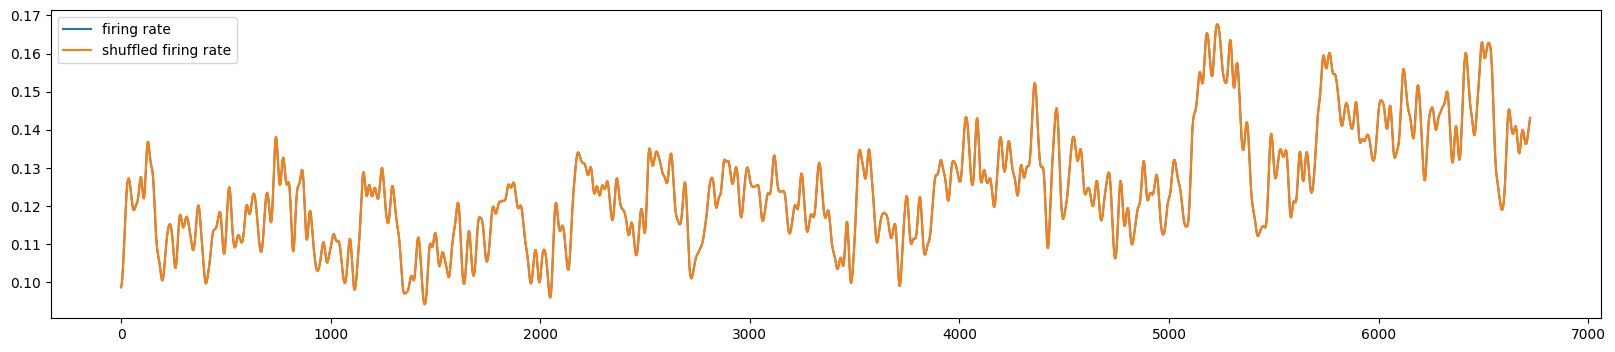

In [20]:
n_trials, n_times, n_neurons = spike_convolved.shape
spike_convolved_shuff = np.zeros((n_trials, n_times, n_neurons))
list_idx = []
for t, idx, in target.groupby(['trial_type', 'position']).groups.items():
    idx = idx.values
    list_idx.append(idx)
    spike_convolved_shuff[idx,:,:] = destroy_corr(spike_convolved[idx,:,:], target.loc[idx,'position'].values)

plt.figure(figsize=(20,4))
plt.plot(spike_convolved[list_idx[2],:,:].mean(axis=(0,2)), label='firing rate')
plt.plot(spike_convolved_shuff[list_idx[2],:,:].mean(axis=(0,2)), label='shuffled firing rate')
plt.legend();

np.save(result_path + 'spike_convol_shuff.npy', spike_convolved_shuff)

## Instantaneous Synchrony

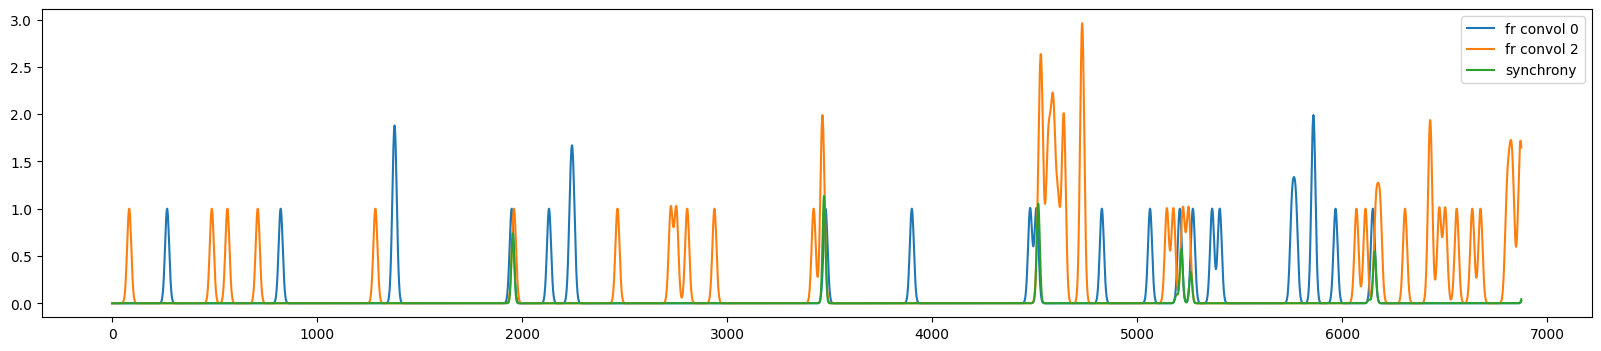

In [22]:
# Étape 1: Créer un dictionnaire pour mapper les labels d'unité à leur Probe et channel correspondants
unit_mapping = {}
for label in unit_label:
    probe, channel, _ = label.split('-')
    unit_mapping[label] = (probe, int(channel))

# Étape 2: Créer une liste de toutes les paires de neurones possibles
neuron_pairs = list(itertools.combinations(unit_label, 2))


# Étape 3: Filtrer les paires de neurones qui sont sur la même Probe mais pas sur la même channel
filtered_neuron_pairs = []
for pair in neuron_pairs:
    probe1, channel1 = unit_mapping[pair[0]]
    probe2, channel2 = unit_mapping[pair[1]]
    if probe1 != probe2 :
        filtered_neuron_pairs.append((unit_label.index(pair[0]), unit_label.index(pair[1])))
    elif probe1 == probe2 and channel1 != channel2:
        filtered_neuron_pairs.append((unit_label.index(pair[0]), unit_label.index(pair[1])))
        
n_pairs = len(filtered_neuron_pairs)
# Créer une matrice pour stocker les résultats de la synchronie filtrée
filtered_Synch = np.zeros((n_trials, n_times, n_pairs))

# Calculer la synchronie pour chaque paire filtrée
for i, (r, c) in enumerate(filtered_neuron_pairs):
    for t in range(n_trials):
        filtered_Synch[t, :, i] = spike_convolved[t, :, r] * spike_convolved[t, :, c]

n0 = 0
n1 = 2
neurons_ = [n0,n1]
plt.figure(figsize=(20,4))
plt.plot(spike_convolved[121,:,n0], label=f'fr convol {n0}')
plt.plot(spike_convolved[121,:,n1], label=f'fr convol {n1}')
plt.plot(filtered_Synch[121,:,1], label='synchrony')
plt.legend()


np.save(result_path + 'synchrony.npy', filtered_Synch)

# Shuffled synchrony

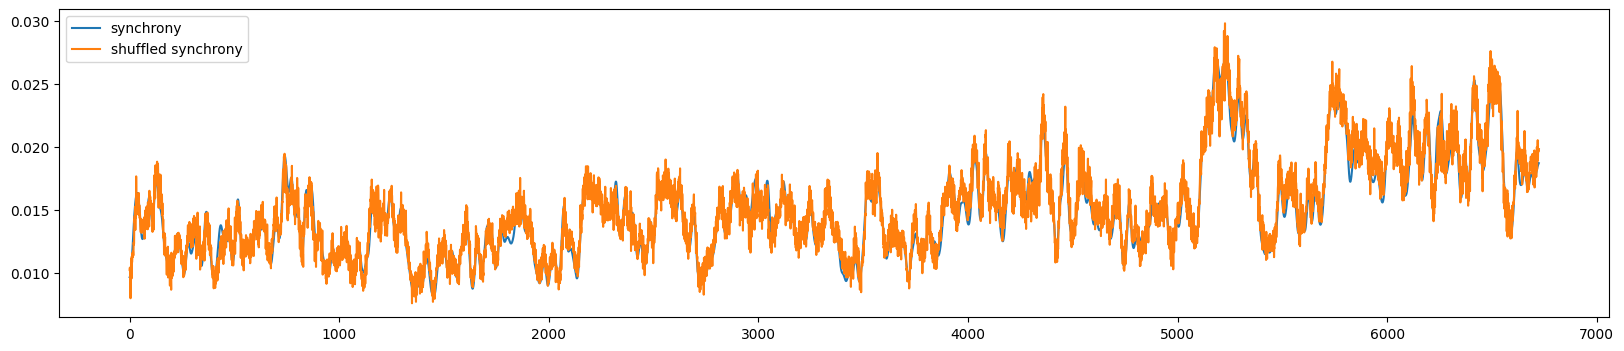

In [23]:
filtered_Synch_shuff = np.zeros((n_trials, n_times, n_pairs))

# Calculer la synchronie pour chaque paire filtrée
for i, (r, c) in enumerate(filtered_neuron_pairs):
    for t in range(n_trials):
        filtered_Synch_shuff[t, :, i] = spike_convolved[t, :, r] * spike_convolved_shuff[t, :, c]

np.save(result_path + 'synchrony_shuff.npy', filtered_Synch_shuff)

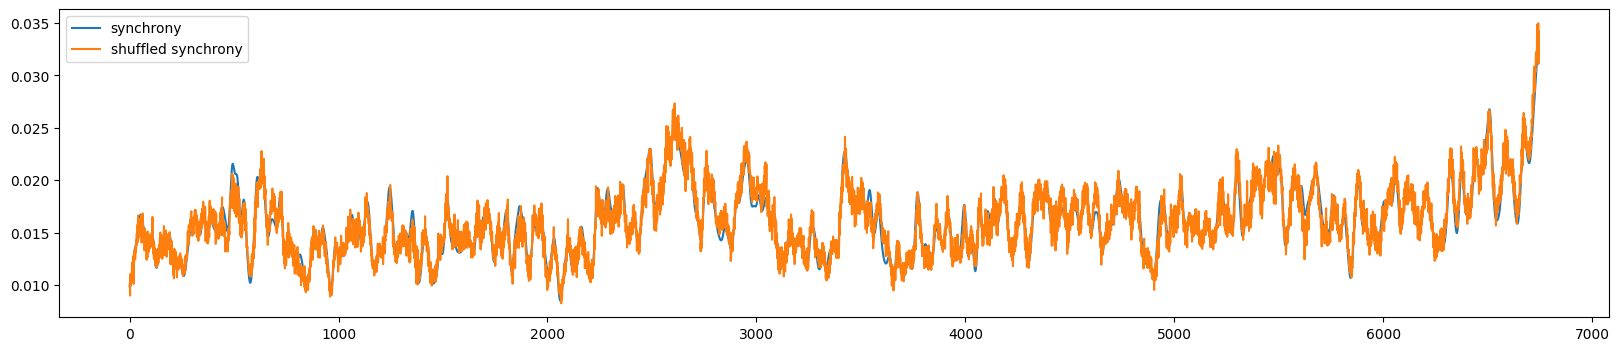

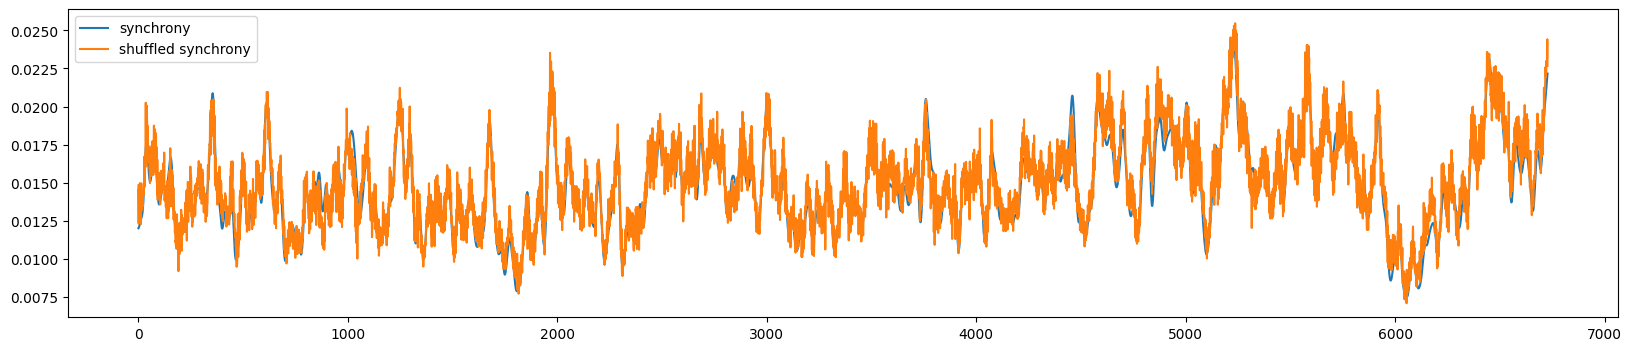

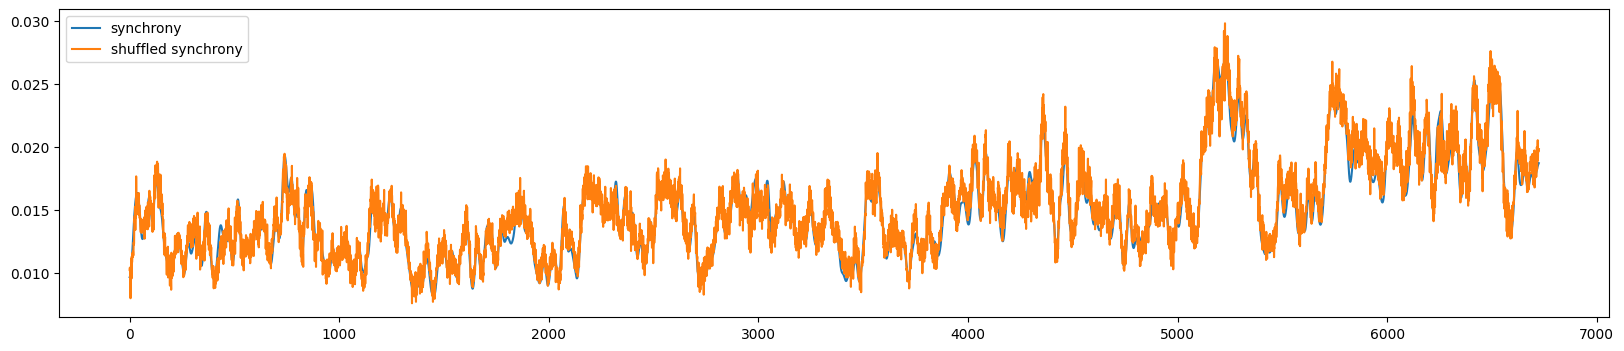

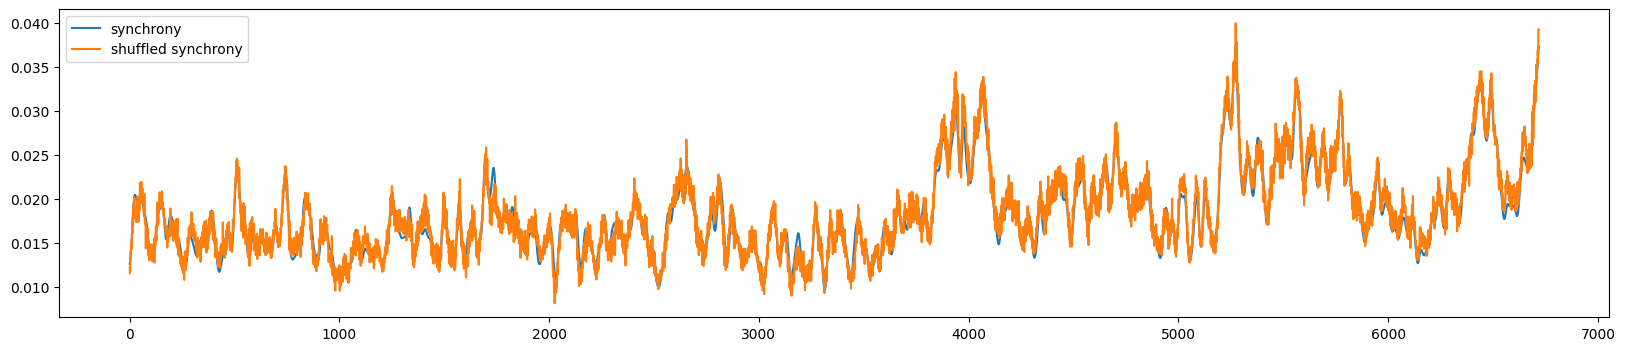

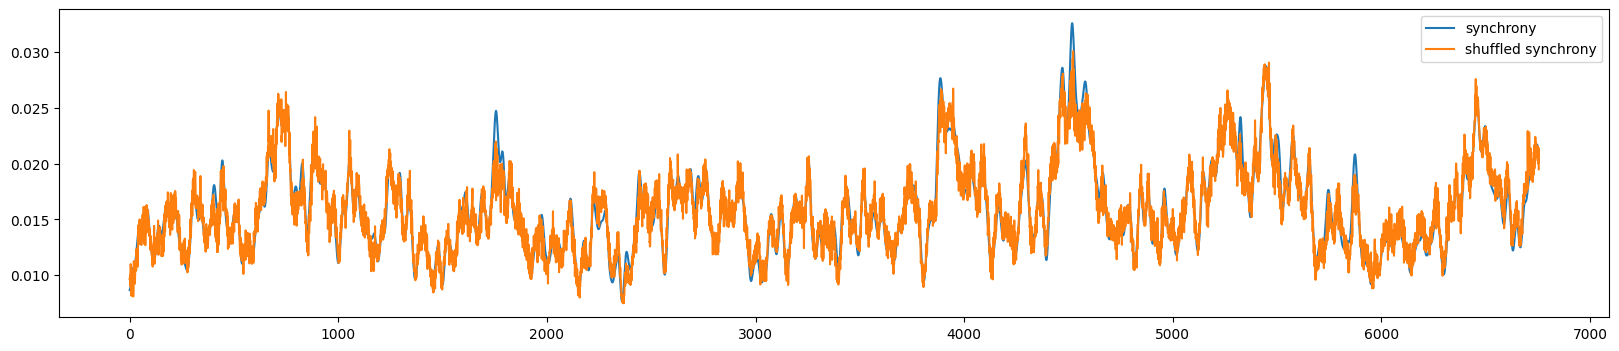

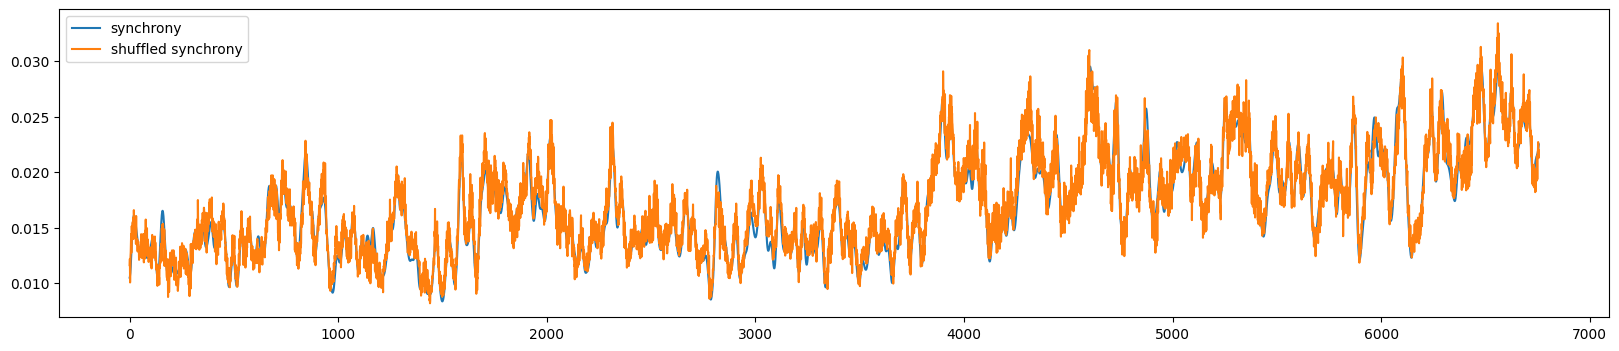

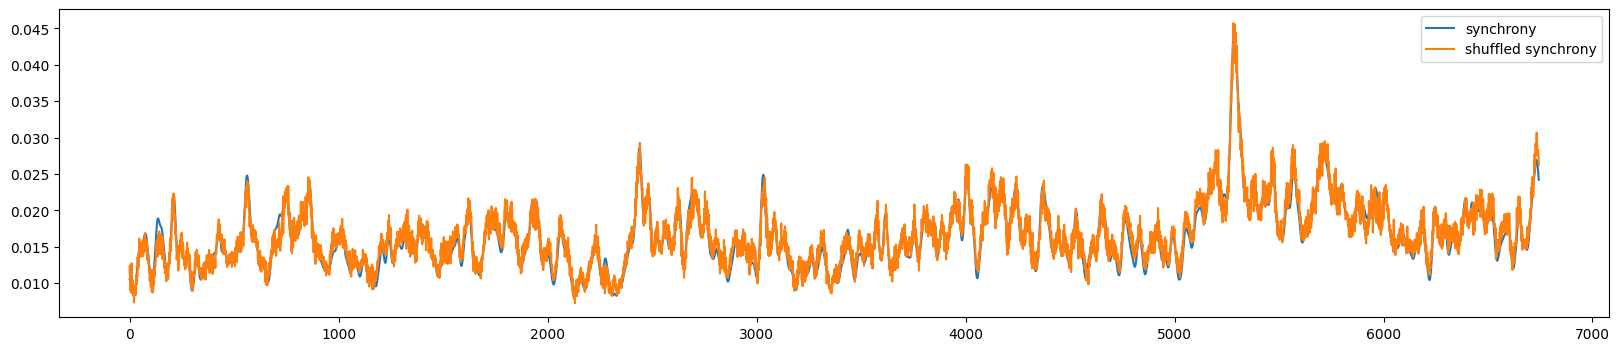

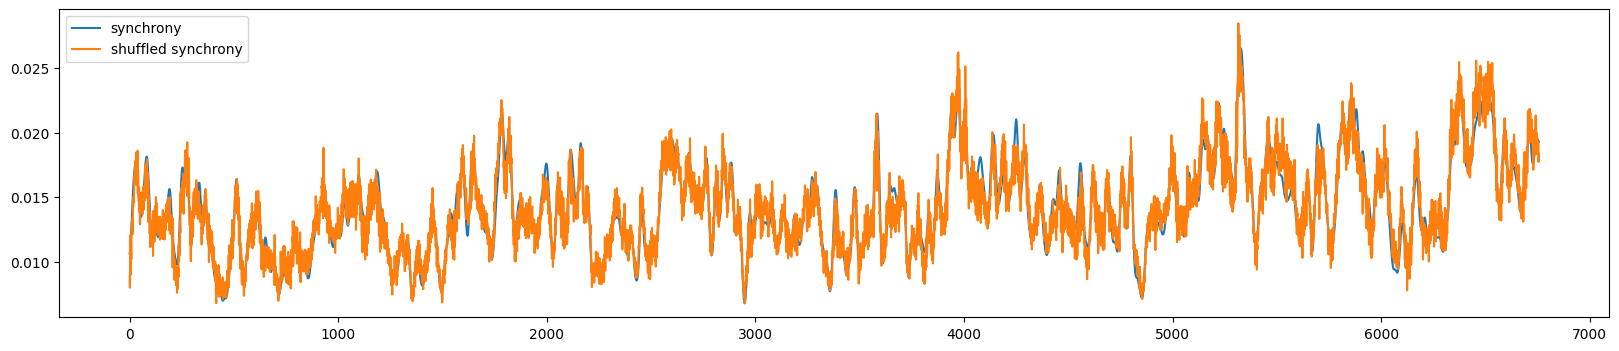

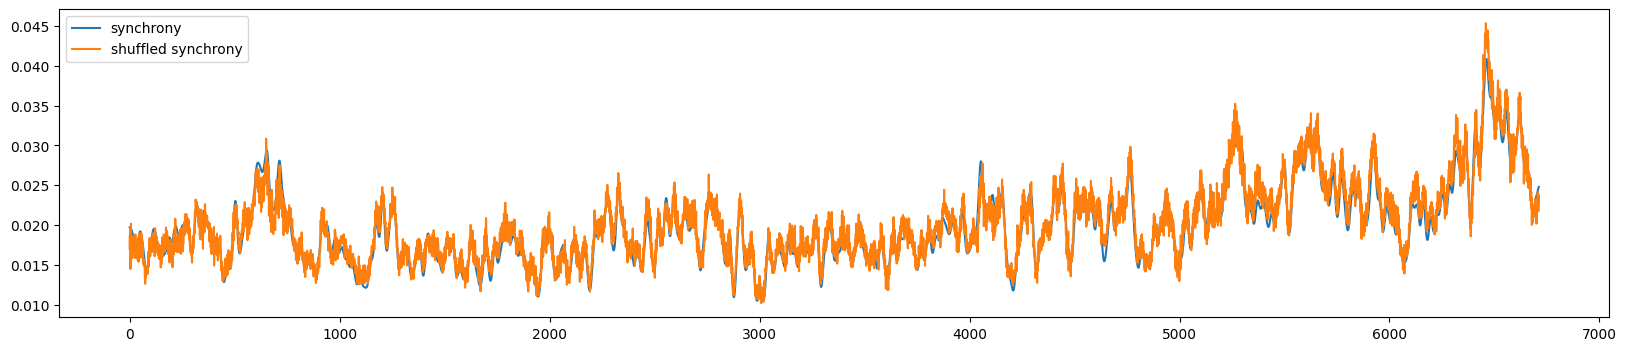

In [25]:

for i in range(len(list_idx)):
    plt.figure(figsize=(20,4))
    plt.plot(filtered_Synch[list_idx[i],:,:].mean(axis=(0,2)), label='synchrony')
    plt.plot(filtered_Synch_shuff[list_idx[i],:,:].mean(axis=(0,2)), label='shuffled synchrony')
    plt.legend();